## this homework will be split into 2. In the first part, due by Thursday 9th at noon, you will engineer features from time series. In the second half, due Wednesday 15th at midnight, you will use those features to find structure in the feature space (unsupervised learning, i.e. clustering) and classify by example with CART (supervised learning with random forest or gradient boosted tree models)

# Classifying astrophysical transients from photometry

## OVERVIEW

The PLAsTiCC challenge is a Kaggle challange to classify astrophysical objects (e.g. stars, exploding stars, stars with planets transiting, black holes) based on their time variability in the light emission in 6 different bands. The sampling (the cadence of the observations) is designed to show what the upcming Rubin Observatory LSST (Legacy Survey of Space and Time) will see when it starts observing (in 2023). 

You can refer to this notebook https://www.kaggle.com/michaelapers/the-plasticc-astronomy-starter-kit (written by my good riend Gautham Narayan in fact!) to get started and ingest and preprocess the PLASTiCC challenge data. However, this is written with a class (object oriented) and we have not talked about this syntax in class. If you are not familiar with classes do not worry about it (but you should learn them!). Also I do want you to extract the features yourself. So use it as a guideline, but do not just copy and paste.

Your task is to extract features, i.e. representations of the time series, and run 2 models on these feautes: a cluster model, and a classification tree. 



In [1]:
import pandas as pd
import numpy as np
import pylab as pl
from matplotlib import pyplot as plt
%matplotlib inline

%pylab inline



Populating the interactive namespace from numpy and matplotlib


# TASK:  Data Acquisition
 You can download the data from kaggle
 --- https://www.kaggle.com/c/PLAsTiCC-2018
 or from zenodo
 --- https://zenodo.org/record/2539456#.XonrIdNKjOQ
 Choose how to do it but make sure that it is a reproducible way (i.e. that Yuqi can grade each notebook and the data will be accessed automatically without modifications to the code). You will need the training data and the metadata files


In [2]:
# NOTE::: this is not a reproducible way to do it!!!!!! this would cost points

lcvs = pd.read_csv("https://raw.githubusercontent.com/JinbiaoJi/MLTSA_JJi/master/HW5/PLAsTiCC-2018/training_set.csv")

# The Zenodo data include 1.4 million datapoints. 
## -- I am subsampling the data to develop the code 
# by using only the first 10000 datapoints (lcvs[:10000])
## -- When I am done I will run this on the larger dataset (commenting out #[:10000])
## note that I am choosing the first N=1000, as opposed to 1 every 100 or whatever 
## because there are 6 time series per obects in 6 filters (colors)
lcvs = lcvs
print("The dataset contains: (observations, columns)", lcvs.shape)

The dataset contains: (observations, columns) (1421705, 6)


In [3]:
lcvs.head()

,object_id,mjd,passband,flux,flux_err,detected
0,615,59750.4229,2,-544.810303,3.622952,1
1,615,59750.4306,1,-816.434326,5.553370,1
2,615,59750.4383,3,-471.385529,3.801213,1
3,615,59750.4450,4,-388.984985,11.395031,1
4,615,59752.4070,2,-681.858887,4.041204,1


read the Kaggle challenge for a description of the data . This "Starter Kit" which includes a notebook (written by y good friend Gautham Narayan) may be especially useful
https://www.kaggle.com/michaelapers/the-plasticc-astronomy-starter-kit

For each object there are 6 time series in 6 different passbands (see overview.) 

In [4]:
bands = lcvs["passband"].unique()
print("Passbands (filter) identifiers:", bands)

Passbands (filter) identifiers: [2 1 3 4 5 0]


In [5]:
objects = lcvs["object_id"].unique()
print("There are {} astrophysical simulated objects in my dataset".format(objects.shape[0]))

There are 7848 astrophysical simulated objects in my dataset


In [6]:
metadata = pd.read_csv("https://raw.githubusercontent.com/JinbiaoJi/MLTSA_JJi/master/HW5/PLAsTiCC-2018/training_set_metadata.csv")
metadata.head()

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,NaN,0.017,92
1,713,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,0.2552,45.4063,0.007,88
2,730,33.574219,-6.579593,170.455585,-61.548219,1,0.2320,0.2262,0.0157,40.2561,0.021,42
3,745,0.189873,-45.586655,328.254458,-68.969298,1,0.3037,0.2813,1.1523,40.7951,0.007,90
4,1124,352.711273,-63.823658,316.922299,-51.059403,1,0.1934,0.2415,0.0176,40.4166,0.024,90


In [7]:
print("The metadata dataset contains more information for each time series: (time-series, columns)", metadata.shape)

The metadata dataset contains more information for each time series: (time-series, columns) (7848, 12)


* Deliverable: make sure you print statements like the ones above summarizing the size of the datasets you acquire and you show the beginning of each dataset



# TASK : data visualization - plot some time series 
You always need to visualize your data to get a sense of what we are working with
that for each object I have 6 bands: each object is plotted separately, all bands for each object are plotted together.

**Include object 84716**


In [58]:
# preparing a normalization to pass to the color map to map red filters to red blue filters to blue
norm_band = Normalize(vmin=bands.min(), vmax=bands.max())

In [9]:
objects.size

7848

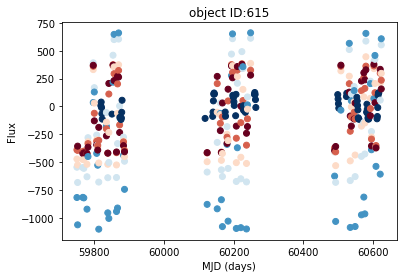

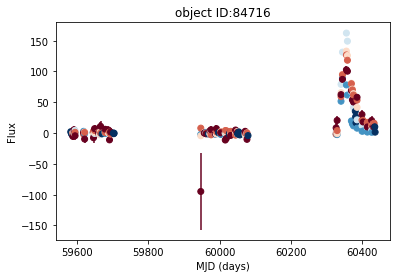

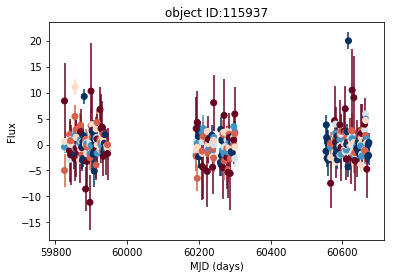

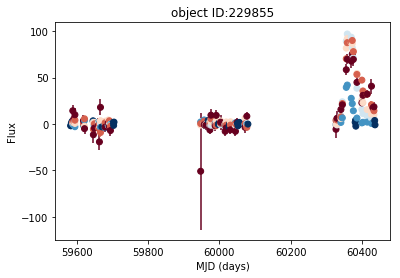

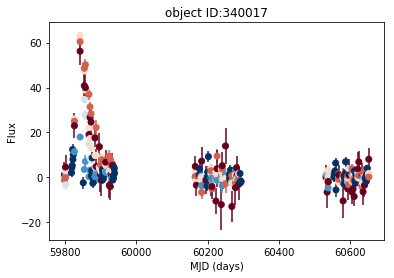

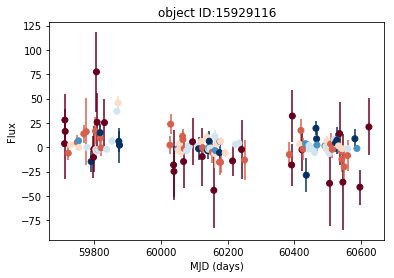

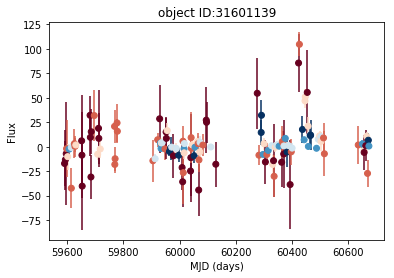

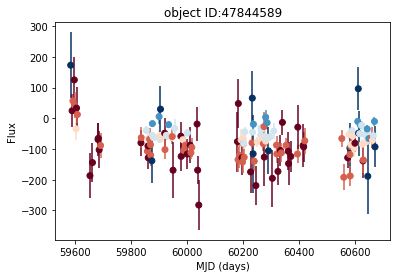

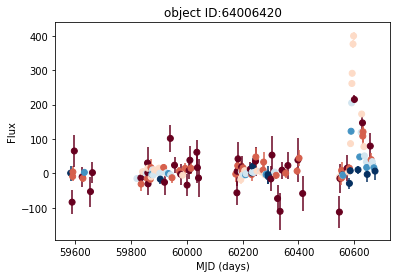

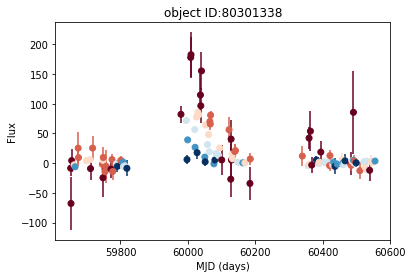

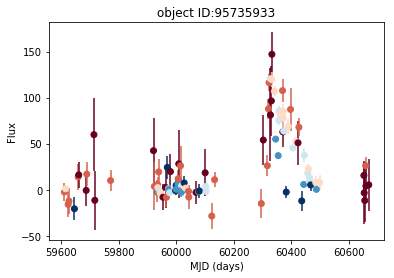

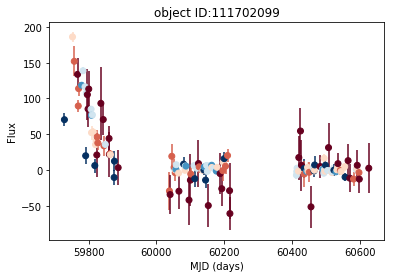

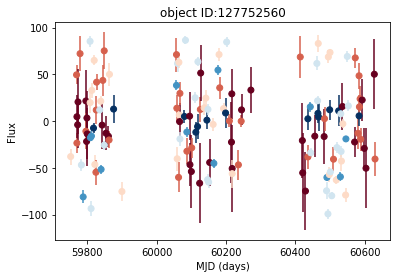

In [10]:
import matplotlib.cm as cm

subsample = np.sort(np.append(np.arange(0,objects.size,700),np.where(objects == 84716),))

for id in subsample:
    fig,ax =plt.subplots(figsize=(6,4))
    
    sc = ax.scatter(x=lcvs[lcvs['object_id'] == objects[id]].mjd,
               y=lcvs[lcvs['object_id'] == objects[id]].flux,
              c=lcvs[lcvs['object_id'] == objects[id]].passband.values, 
                                                cmap='RdBu_r',zorder=3,norm=norm_band)
    
    a,b,c = ax.errorbar(x=lcvs[lcvs['object_id'] == objects[id]].mjd,
               y=lcvs[lcvs['object_id'] == objects[id]].flux,
               yerr=lcvs[lcvs['object_id'] == objects[id]].flux_err,marker='',
                barsabove=False,ls='None',zorder=1)
    
    
    mapper = cm.ScalarMappable(norm=norm_band, cmap='RdBu_r')
    c_color = np.array([(mapper.to_rgba(v)) for v in lcvs[lcvs['object_id'] == objects[id]].passband.values])
    
    c[0].set_color(c_color)
    
    ax.set_title('object ID:{0}'.format(objects[id]))
    ax.set_xlabel('MJD (days)') 
    ax.set_ylabel('Flux')
    
#     lcvs[lcvs['object_id'] == objects[id]].plot(ax = ax,x='mjd',y='flux',yerr='flux_err',kind='scatter',
#                                            title='object ID:{0}'.format(objects[id]),
#                                       c=norm_band(lcvs[lcvs['object_id'] == objects[id]].passband.values), 
#                                                 cmap='RdBu_r',colorbar=False)
   

**Figure 1.** It shows Flux vs. MJD (modified Julian dates) for  13 objects. The color represents 6 different passbands that are used to observe each object. There are two large gaps in the data since data were not taken all the time. Some objects show a sudden burst of flux indicating there could be some astrophysical events like flares, such as object 84716 and 340017. Some objects show outliers in the flux such as object 84716 and some fluxes have very larger uncertainty like object 229855.

* Deliverable: make a plot for a subset of the objects (~10 at least). Describe what you are plotting and any notable things you see in the figure. Make sure you plot the time series (flux) against time (mjd) and also display the uncertainties int he measurement (fluxerr)

---

# TASK: Extract features
*You do not have to extract exaclyt the features I am extracting! These are just examples! Extract at least 6 features including 2 features from all three category below* 

The code that won the callenge did a number of smart things, of course. It was a feature based classification scheme, which included Gaussian Processes in the preprocessing. The feature extraction part of the code is here. https://github.com/kboone/avocado/blob/master/avocado/plasticc.py

We will work similarly, extracting some basic features for each lightcurve. 

Note: we are working with bigg-ish data! 
First off: every new piece should be developed on a subset of the dataset, then run on all the data only when ready. 
Still, if you try achieve goals by implementing for loops you are not going to be able to run the notebook for the whole data, or even only 1 batch of the full datase. A good solution is to use the groupby() method in pandas. I used groupby everywhere. Also it may be wise to write out intermediate outputs, so you do not have to loose work if your kernel dies or something similar. 

My plan is to extract:

- **from the original lightcurve**: 
    - mean, 
    - standard deviation, 
    - skewness, 
    - kurthosis, 
    - minimum 
    - maximmum,
    - error on the minimum and 
    - error on the maximum, 
- **from the standardized lightcurve**:
    - median 
    - slop of a line fit
    - intercept of a line fit
    - likelihood of the line fit
    - likelihood of a quadratic fit
    - sign of the quadratic parameter


- **from the metadata file**:
    - decl ; important because the position on the sky may determin if it is a galactic or extragalactic object
    - ddf_bool ; the kind of survey i.e. the data collection scheme that lead to the time series
    - hostgal_photoz
    - hostgal_photoz_err
    
The feature in the metadata files are the hardest ones to decide on because they require domain knowledge.
Most of the other features in the metadata are unknown for test objects (only known for the training set)

I am ok with you extracting different features! 

Extract **at least 6 features including 2 features from all three category above**: original lcv, standardized lcv, metadata. Justify each feature. Remember that if the features are extracted from the time series there will be 6 features for each choice of feature (for 6 passbands) so I end up with 94 features with the scheme outlined above

## TASK: 4.1
describe each feature you plan to extract. Briefly indicate why you think it is a valuable feature and what data type is it (e.g. continuous, binary, categorical, if continuous does it have a max or min value or is it unbound?)

        

- **From the original lightcurve**: 
    - **mean:** It's a valuable feature because it tells the average flux of that object, giving us an idea of it's brightness. It's an unbounded continuous variable.
    - **standard deviation:** It's a valuable feature because it tells us how spread out the flux are, which can help us know whether it's a quiet celestial object or active object, and can help us determine its type. It's an unbounded continuous variable.
    - **skewness:** It can tell us the asymmetry of the distribution of the time series (flux). The asymmetry of flux distribution may indicate some astronomical events like many flares or supernova. It's an unbounded continuous variable.
- **From the standardized lightcurve**:
    - **median:** It's important because it can tell us the brightness of that object excluding outliers in the data. It's an unbounded continuous variable.
    - **slope of a line fit:** It can tell us the change rate of the flux, so we can know that whether there is a change of background or some events that make the magnitude of that object changes. It's an unbounded continuous variable.


- **From the metadata file**:
    - **decl** :It's important because the position on the sky may determin if it is a galactic or extragalactic object, It's a bounded continuous variable because there is a range for celestial coordinates (-90 to +90 degree).
    - **ddf_bool:** the kind of survey i.e. the data collection scheme that lead to the time series. It's important because it tells us what kind of data collection method was used. It's a boolen variable.
    - **hostgal_photoz:** The photometric redshift of the host galaxy of the astronomical source. It's valuable because it gives a sence of its distance from the solar system. It's a bounded continuous variable. The observed highest redshift is 11.1 which is the galaxy GN-z11.
    

## TASK 4.2 extract some features from the raw lightcurve - 
I have some examples of how I did it in the next few lines of code

### Example get the mean and standard deviation of the flux in each band for each object

In [11]:
means = lcvs.groupby(["object_id", "passband"])[["flux"]].mean()
stds = lcvs.groupby(["object_id", "passband"])[["flux"]].std()
skews = lcvs.groupby(["object_id", "passband"])[["flux"]].skew()

In [12]:
features = means.rename({"flux": "mean"}, 
                        axis=1).merge(stds.rename({"flux": "std"}, 
                        axis=1), left_index=True, 
                    right_index=True).merge(skews.rename({'flux':'skew'},axis=1),
                left_index=True, right_index=True)

features.head()

mean         std      skew
object_id passband                                  
615       0          -3.254554   83.944735  0.128917
          1        -385.699911  601.787302  0.415580
          2        -134.146566  455.121346  0.339918
          3        -121.103501  335.425053  0.293128
          4         -55.954592  291.803449  0.200096

### higher order moments of the distribution can be obtained with the scipy.stats.moment() function which can be applied to a grouby() object
note that this way you can apply a function that takes only one argument, the argument over which groupby iterates (the flux here). But moments take 2: the value and the moment Create a unction call

In [13]:
from scipy import stats 
def moment2(x):
    return stats.moment(x, moment = 2)
def moment3(x):
    return stats.moment(x, moment = 3)

m2 = lcvs.groupby(["object_id", "passband"])["flux"].apply(moment2)
m3 = lcvs.groupby(["object_id", "passband"])["flux"].apply(moment3)

In [14]:
m2.rename({'flux':'moment2'})
m3.rename({'flux':'moment3'})
features2 = pd.concat([m2,m3],axis=1)
features2.columns = ['moment2', 'moment3']
features2.head()

moment2       moment3
object_id passband                             
615       0           6934.865833  7.266579e+04
          1         355904.026224  8.593916e+07
          2         203564.138816  3.040627e+07
          3         110570.138947  1.049664e+07
          4          83681.162283  4.717542e+06

In [15]:
features = pd.merge(features, features2,left_index=True,right_index=True)

### Even with the same standard deviation two distributions can be very different. 
Look at the this article for a great demonstation of that! https://heap.io/blog/data-stories/anscombes-quartet-and-why-summary-statistics-dont-tell-the-whole-story

I extracted  the max and min, but also their uncertainties because outlier points may be measurement issues, in which case the uncertainty may be large : see the plot you made for 84716!

If a distribution has spikes the standard deviation will be larger even if the other datapoints are exactly the same. Save the mean and the max of both original distribution and the standardized one (standardized = mean subtracted and divided by the standard deviation). 


In [16]:
maxs = lcvs.groupby(["object_id", "passband"])["flux"].max()
mins = lcvs.groupby(["object_id", "passband"])["flux"].min()

In [17]:
maxs.rename({'flux':'max'})
mins.rename({'flux':'min'})
features3 = pd.concat([maxs,mins],axis=1)
features3.columns = ['max', 'min']
features3.head()

max          min
object_id passband                         
615       0         125.182808  -116.913223
          1         660.626343 -1100.440063
          2         611.984558  -681.858887
          3         445.737061  -530.644592
          4         381.953735  -422.184509

In [18]:
features = pd.merge(features, features3,left_index=True,right_index=True)

In [19]:
features.head()

mean         std      skew        moment2  \
object_id passband                                                    
615       0          -3.254554   83.944735  0.128917    6934.865833   
          1        -385.699911  601.787302  0.415580  355904.026224   
          2        -134.146566  455.121346  0.339918  203564.138816   
          3        -121.103501  335.425053  0.293128  110570.138947   
          4         -55.954592  291.803449  0.200096   83681.162283   

                         moment3         max          min  
object_id passband                                         
615       0         7.266579e+04  125.182808  -116.913223  
          1         8.593916e+07  660.626343 -1100.440063  
          2         3.040627e+07  611.984558  -681.858887  
          3         1.049664e+07  445.737061  -530.644592  
          4         4.717542e+06  381.953735  -422.184509

## TASK 4.3 Standardize the lcvs and extract some features from the raw lightcurve - 
I have some examples of how I did it in the next few lines of code

In [20]:
lcvs["fluxnormed"] = 0.

In [21]:
# normalize each LC this is very slow. can you make  it faster?
def normed(df):
    
    df = (df[['flux']] - df[['flux']].mean())/ df[['flux']].std()
    
    return df
    
    

lcvs['fluxnormed'] = lcvs.groupby(["object_id", "passband"]).apply(normed)

# this is how it could be done in a for loop. But it would take hours!!
#for obj in  objects:
#    for band in bands:
#        lcvs[lcvs.object_id == obj][lcvs.passband == band].normedflux =\
#             lcvs[lcvs.object_id == obj][lcvs.passband == band].flux - means.loc[obj, band]
#        lcvs[lcvs.object_id == obj][lcvs.passband == band].normedflux /= stds.loc[obj, band]        


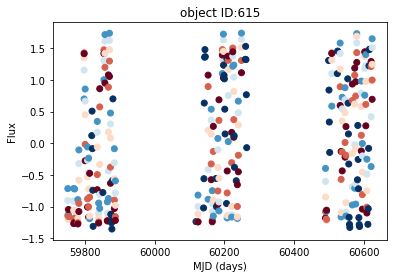

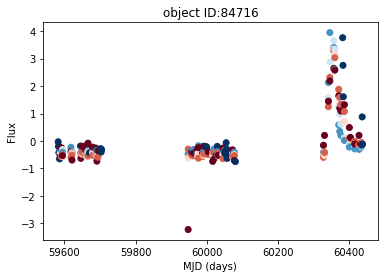

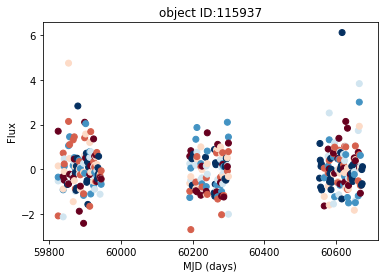

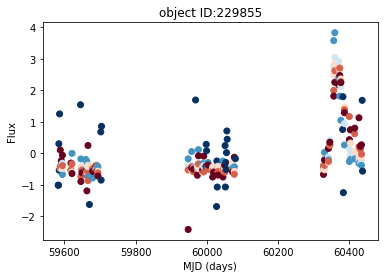

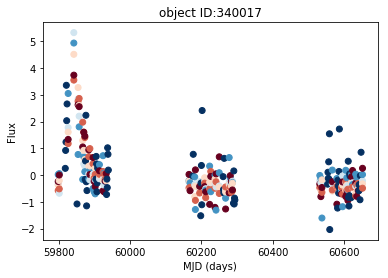

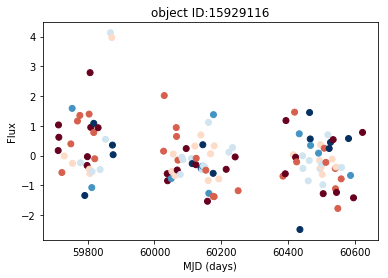

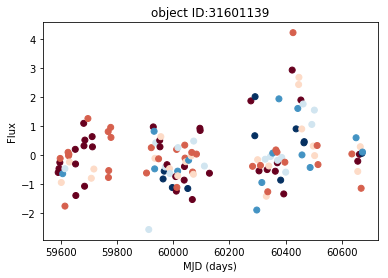

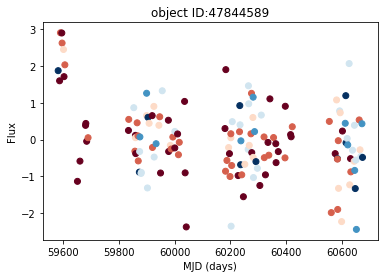

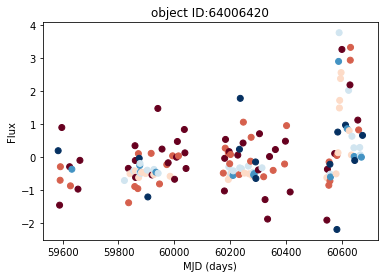

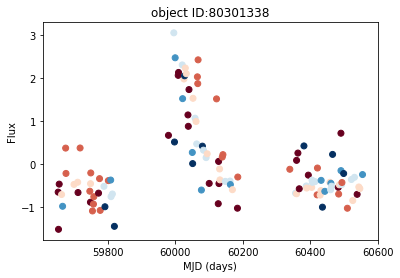

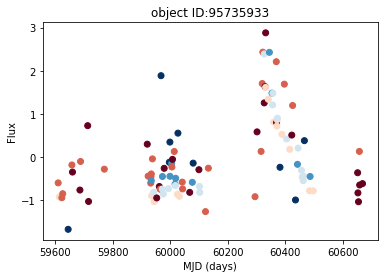

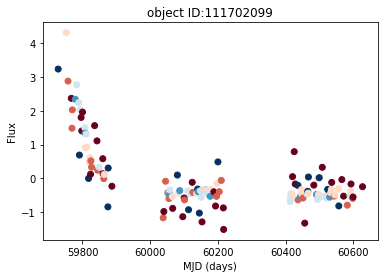

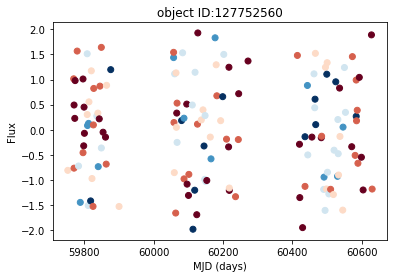

In [22]:
for id in subsample:
    fig,ax =plt.subplots(figsize=(6,4))
    
    sc = ax.scatter(x=lcvs[lcvs['object_id'] == objects[id]].mjd,
               y=lcvs[lcvs['object_id'] == objects[id]].fluxnormed,
              c=lcvs[lcvs['object_id'] == objects[id]].passband.values, 
                                                cmap='RdBu_r',norm=norm_band)
    
#     a,b,c = ax.errorbar(x=lcvs[lcvs['object_id'] == objects[id]].mjd,
#                y=lcvs[lcvs['object_id'] == objects[id]].flux,
#                yerr=lcvs[lcvs['object_id'] == objects[id]].flux_err,marker='',
#                 barsabove=False,ls='None',zorder=1)
    
    
#     mapper = cm.ScalarMappable(norm=norm_band, cmap='RdBu_r')
#     c_color = np.array([(mapper.to_rgba(v)) for v in lcvs[lcvs['object_id'] == objects[id]].passband.values])
    
#     c[0].set_color(c_color)
    
    ax.set_title('object ID:{0}'.format(objects[id]))
    ax.set_xlabel('MJD (days)') 
    ax.set_ylabel('Flux')

**Figure 2:** These plots show the normalized flux against time for the same subsample for Figure 1. 

### min and max: if I did not get the means before I would store these data. since I have the mean and the min max of the not standardized data this is irrelevant


In [23]:
maxs_standardized = lcvs.groupby(["object_id", "passband"])["fluxnormed"].max()
mins_standardized = lcvs.groupby(["object_id", "passband"])["fluxnormed"].min()

### the median of the standardizeed distribution will convey the location of the "center of mass" of the data with respect to the mean


In [24]:
medians = lcvs.groupby(["object_id", "passband"])[["fluxnormed"]].median()

In [25]:
features = features.merge(medians.rename({"fluxnormed": "median"}, axis=1), left_index=True, right_index=True)
features.head()

mean         std      skew        moment2  \
object_id passband                                                    
615       0          -3.254554   83.944735  0.128917    6934.865833   
          1        -385.699911  601.787302  0.415580  355904.026224   
          2        -134.146566  455.121346  0.339918  203564.138816   
          3        -121.103501  335.425053  0.293128  110570.138947   
          4         -55.954592  291.803449  0.200096   83681.162283   

                         moment3         max          min    median  
object_id passband                                                   
615       0         7.266579e+04  125.182808  -116.913223 -0.080537  
          1         8.593916e+07  660.626343 -1100.440063 -0.170090  
          2         3.040627e+07  611.984558  -681.858887 -0.289021  
          3         1.049664e+07  445.737061  -530.644592 -0.122434  
          4         4.717542e+06  381.953735  -422.184509 -0.163078

## TASK 4.4: parametric features: extract some features that come from simple models of the lightcurve



### fit a line to the standardized data and store the slope and intercept as new features. See here for how to apply this with a groupby https://stackoverflow.com/questions/14529838/apply-multiple-functions-to-multiple-groupby-columns
If you can use groupby you get an extra point (cause that would be a very efficient way to do it)

In [26]:
def linfit(x):
    pars = np.polyfit(range(len(x)), x["fluxnormed"].values, 1)
    return pars
linfits = lcvs.groupby(["object_id", "passband"]).apply(linfit)

In [27]:
linfits.shape

(47088,)

In [28]:
slopes = [x[0] for x in linfits.values[:]]
intercepts = [x[1] for x in linfits.values[:]]


In [29]:
features["slopes"] = slopes
features["intercepts"] = intercepts

In [30]:
features.head()

mean         std      skew        moment2  \
object_id passband                                                    
615       0          -3.254554   83.944735  0.128917    6934.865833   
          1        -385.699911  601.787302  0.415580  355904.026224   
          2        -134.146566  455.121346  0.339918  203564.138816   
          3        -121.103501  335.425053  0.293128  110570.138947   
          4         -55.954592  291.803449  0.200096   83681.162283   

                         moment3         max          min    median    slopes  \
object_id passband                                                              
615       0         7.266579e+04  125.182808  -116.913223 -0.080537  0.005676   
          1         8.593916e+07  660.626343 -1100.440063 -0.170090  0.014032   
          2         3.040627e+07  611.984558  -681.858887 -0.289021  0.017676   
          3         1.049664e+07  445.737061  -530.644592 -0.122434  0.020475   
          4         4.717542e+06  381.953735  -422.184509 -0.163078  0.022343   

                    intercepts  
object_id passband              
615       0          -0.175947  
          1          -0.399902  
          2          -0.503760  
          3          -0.583524  
          4          -0.636786

### A quadratic function can tell you if the time series is concave or convex. 
### If we fit both line and a quadratic we can also us the likelihood ratio to see wchich fit is best (remember the first couple of classes)

In [31]:
# this is slow!!
from statsmodels.formula.api import ols
def quadfit(x):
    x['t'] = x.mjd - x.iloc[0].mjd
    m1 = ols(formula='fluxnormed~t + 1', data=x).fit()
    m2 = ols(formula='fluxnormed~pow(t, 2) + t + 1', data=x).fit()
    
    pars = m2.llf, m1.llf, np.sign(m2.params[1])
    return pars
ols = lcvs.groupby(["object_id", "passband"]).apply(quadfit)

In [32]:
ll1 = [x[1] for x in ols.values[:]]
ll2 = [x[0] for x in ols.values[:]]
ll3 = [x[2] for x in ols.values[:]]
features["ll1"] = ll1
features["ll2"] = ll2
features["ll3"] = ll3

## Task 5: show your engineered feature space and add features from the metadata file

Note that in the way I cereated the feature dataframe I have a feature column for each object and bandpass. I need to manipulate the dataframe so that I have 6xN features per object where N is the number of eatures I engineered. 

In [33]:
features.head()

mean         std      skew        moment2  \
object_id passband                                                    
615       0          -3.254554   83.944735  0.128917    6934.865833   
          1        -385.699911  601.787302  0.415580  355904.026224   
          2        -134.146566  455.121346  0.339918  203564.138816   
          3        -121.103501  335.425053  0.293128  110570.138947   
          4         -55.954592  291.803449  0.200096   83681.162283   

                         moment3         max          min    median    slopes  \
object_id passband                                                              
615       0         7.266579e+04  125.182808  -116.913223 -0.080537  0.005676   
          1         8.593916e+07  660.626343 -1100.440063 -0.170090  0.014032   
          2         3.040627e+07  611.984558  -681.858887 -0.289021  0.017676   
          3         1.049664e+07  445.737061  -530.644592 -0.122434  0.020475   
          4         4.717542e+06  381.953735  -422.184509 -0.163078  0.022343   

                    intercepts        ll1        ll2  ll3  
object_id passband                                         
615       0          -0.175947 -88.218652 -84.013092 -1.0  
          1          -0.399902 -80.869998 -80.867915 -1.0  
          2          -0.503760 -80.109763 -80.092803 -1.0  
          3          -0.583524 -79.290039 -79.226482 -1.0  
          4          -0.636786 -78.480261 -78.160027 -1.0

In [34]:
# unstack will do the trick ... 
allfeatures = features.reset_index().set_index(['object_id','passband']).stack(
    ).unstack([1,2])


In [35]:
allfeatures.head()

passband          0                                                  \
               mean        std      skew      moment2       moment3   
object_id                                                             
615       -3.254554  83.944735  0.128917  6934.865833  72665.792850   
713       -2.720398   7.113509  0.260052    49.879128     89.634243   
730       -0.048080   1.828872  0.356910     3.298318      2.093148   
745        1.797523   4.374445  2.023211    18.869993    162.368381   
1124       0.660948   2.360084 -0.332169     5.481586     -4.160853   

passband                                                          ...  \
                  max         min    median    slopes intercepts  ...   
object_id                                                         ...   
615        125.182808 -116.913223 -0.080537  0.005676  -0.175947  ...   
713         14.509829  -14.735178 -0.052914 -0.041433   1.429423  ...   
730          5.942166   -3.459960  0.039463 -0.001798   0.063840  ...   
745         18.014029   -3.874349 -0.169349 -0.013089   0.464675  ...   
1124         5.330927   -6.804703 -0.033864  0.017117  -0.530614  ...   

passband              5                                                  \
                moment2       moment3         max         min    median   
object_id                                                                 
615        85370.493377  3.041829e+06  378.188141 -422.815094 -0.129163   
713           49.427194  7.377121e+01   14.770886  -14.211164 -0.094281   
730          174.276892  3.751336e+03   47.310059  -19.159811 -0.149763   
745          666.782529  5.309464e+04  141.513290  -10.249387 -0.306851   
1124         451.382820  3.414365e+04  109.157585  -10.860540 -0.229697   

passband                                                   
             slopes intercepts        ll1        ll2  ll3  
object_id                                                  
615        0.021319  -0.596932 -77.386461 -76.917754 -1.0  
713       -0.037903   1.042343 -65.424297 -65.167686 -1.0  
730        0.019612  -0.490299 -67.853917 -66.518080  1.0  
745       -0.002816   0.076043 -77.536999 -64.783463 -1.0  
1124       0.015555  -0.435534 -76.666778 -76.526495  1.0  

[5 rows x 78 columns]

In [36]:
metadata.head()

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,NaN,0.017,92
1,713,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,0.2552,45.4063,0.007,88
2,730,33.574219,-6.579593,170.455585,-61.548219,1,0.2320,0.2262,0.0157,40.2561,0.021,42
3,745,0.189873,-45.586655,328.254458,-68.969298,1,0.3037,0.2813,1.1523,40.7951,0.007,90
4,1124,352.711273,-63.823658,316.922299,-51.059403,1,0.1934,0.2415,0.0176,40.4166,0.024,90


In [61]:
allfeatures = allfeatures.merge(metadata[["object_id", "decl", "ddf", "hostgal_photoz", 
                                          "hostgal_photoz_err", "target"]], on=['object_id']).drop("object_id", axis=1)
allfeatures.head()

,"(0, mean)","(0, std)","(0, moment2)","(0, moment3)","(0, max)","(0, min)","(0, median)","(0, slopes)","(0, intercepts)","(0, ll1)",...,"(5, ll2)","(5, ll3)",decl_x,ddf_x,hostgal_photoz_x,decl_y,ddf_y,hostgal_photoz_y,hostgal_photoz_err,target
0,-3.254554,83.944735,6934.865833,72665.792850,125.182808,-116.913223,-0.080537,0.005676,-0.175947,-88.218652,...,-76.917754,-1.0,-61.943836,1,0.0000,-61.943836,1,0.0000,0.0000,92
1,-2.720398,7.113509,49.879128,89.634243,14.509829,-14.735178,-0.052914,-0.041433,1.429423,-49.801325,...,-65.167686,-1.0,-27.784405,1,1.6267,-27.784405,1,1.6267,0.2552,88
2,-0.048080,1.828872,3.298318,2.093148,5.942166,-3.459960,0.039463,-0.001798,0.063840,-101.606902,...,-66.518080,1.0,-6.579593,1,0.2262,-6.579593,1,0.2262,0.0157,42
3,1.797523,4.374445,18.869993,162.368381,18.014029,-3.874349,-0.169349,-0.013089,0.464675,-100.184915,...,-64.783463,-1.0,-45.586655,1,0.2813,-45.586655,1,0.2813,1.1523,90
4,0.660948,2.360084,5.481586,-4.160853,5.330927,-6.804703,-0.033864,0.017117,-0.530614,-84.969286,...,-76.526495,1.0,-63.823658,1,0.2415,-63.823658,1,0.2415,0.0176,90


* Deliverable: what is the shape of your final feature space?

In [62]:
print("My feature space is {} features (columns)".format(allfeatures.shape[1]))

My feature space is 85 features (columns)


## Task 6: Create your train and test set out of the feature matrix and preprocess them to remove correlation by scaling them along the feature axis
The goall is to have a fewature matrix, the endogenous variables, X, and the target vector, the y exogenous variable for each training and test set.
Scale your training and test sets to remove the correlation: each feature is preprocessed so that it is mean=0 and standard deviation =1 - we will talk about it in class but make sure you deliver in this notebook the scaled features as below.

### make sure you deal with missing data

In [63]:
# check for NaNs and infinities
print("there are {} NaN and {} infinity entries".format(
 (allfeatures.isna().sum().sum()), np.prod(allfeatures.shape) - (np.isfinite(allfeatures).sum().sum())))


there are 0 NaN and 0 infinity entries


In [64]:
# check for NaNs and infinities
print("there are {} NaN and {} infinity entries".format(
 (allfeatures.isna().sum().sum()), np.prod(allfeatures.shape) - (np.isfinite(allfeatures).sum().sum())))


there are 0 NaN and 0 infinity entries


In [65]:
np.isfinite(allfeatures).sum()

(0, mean)             7848
(0, std)              7848
(0, moment2)          7848
(0, moment3)          7848
(0, max)              7848
(0, min)              7848
(0, median)           7848
(0, slopes)           7848
(0, intercepts)       7848
(0, ll1)              7848
(0, ll2)              7848
(0, ll3)              7848
(1, mean)             7848
(1, std)              7848
(1, skew)             7848
(1, moment2)          7848
(1, moment3)          7848
(1, max)              7848
(1, min)              7848
(1, median)           7848
(1, slopes)           7848
(1, intercepts)       7848
(1, ll1)              7848
(1, ll2)              7848
(1, ll3)              7848
(2, mean)             7848
(2, std)              7848
(2, skew)             7848
(2, moment2)          7848
(2, moment3)          7848
                      ... 
(4, moment3)          7848
(4, max)              7848
(4, min)              7848
(4, median)           7848
(4, slopes)           7848
(4, intercepts)       7848
(

I the problem is with one of the likelihoods. 
I can drop that feature from the dataset or replace with something else. 



In [66]:
## dropping the observation
allfeatures.shape, allfeatures.replace([np.inf, -np.inf], np.nan).dropna().shape


((7848, 85), (7848, 85))

In [67]:
## dropping the feature
allfeatures.shape, allfeatures.replace([np.inf, -np.inf], np.nan).dropna(axis=1).shape


((7848, 85), (7848, 85))

In [68]:
## filling with something else
allfeatures.shape, allfeatures.replace([np.inf, -np.inf], np.nan).fillna(-99).shape


((7848, 85), (7848, 85))

In [69]:
# -- personally I choose to drop the feature 
allfeatures = allfeatures.replace([np.inf, -np.inf], np.nan).dropna(axis=1)
#allfeatures

In [70]:
allfeatures.head()

,"(0, mean)","(0, std)","(0, moment2)","(0, moment3)","(0, max)","(0, min)","(0, median)","(0, slopes)","(0, intercepts)","(0, ll1)",...,"(5, ll2)","(5, ll3)",decl_x,ddf_x,hostgal_photoz_x,decl_y,ddf_y,hostgal_photoz_y,hostgal_photoz_err,target
0,-3.254554,83.944735,6934.865833,72665.792850,125.182808,-116.913223,-0.080537,0.005676,-0.175947,-88.218652,...,-76.917754,-1.0,-61.943836,1,0.0000,-61.943836,1,0.0000,0.0000,92
1,-2.720398,7.113509,49.879128,89.634243,14.509829,-14.735178,-0.052914,-0.041433,1.429423,-49.801325,...,-65.167686,-1.0,-27.784405,1,1.6267,-27.784405,1,1.6267,0.2552,88
2,-0.048080,1.828872,3.298318,2.093148,5.942166,-3.459960,0.039463,-0.001798,0.063840,-101.606902,...,-66.518080,1.0,-6.579593,1,0.2262,-6.579593,1,0.2262,0.0157,42
3,1.797523,4.374445,18.869993,162.368381,18.014029,-3.874349,-0.169349,-0.013089,0.464675,-100.184915,...,-64.783463,-1.0,-45.586655,1,0.2813,-45.586655,1,0.2813,1.1523,90
4,0.660948,2.360084,5.481586,-4.160853,5.330927,-6.804703,-0.033864,0.017117,-0.530614,-84.969286,...,-76.526495,1.0,-63.823658,1,0.2415,-63.823658,1,0.2415,0.0176,90


In [71]:
#allfeatures.to_csv('allfeatures.csv')

## split train-test set

In [46]:
X = allfeatures.iloc[:,:-1]
y = allfeatures.iloc[:,-1]

import sklearn
from sklearn.model_selection import train_test_split

#remember to use the random state so that your work is reproducible and use a split between 60-40 and 75-25. 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=8)

## scale train and test set

In [47]:

from sklearn import preprocessing
Xtrain_scaled = preprocessing.scale(X_train)
Xtest_scaled = preprocessing.scale(X_test)

print("scaled training data feature mean and standard deviations: ", 
      Xtrain_scaled.mean(axis=0), Xtrain_scaled.std(axis=0))



scaled training data feature mean and standard deviations:  [-2.70271105e-18 -2.70271105e-18  2.70271105e-18 -4.05406658e-18
  5.40542211e-18  4.05406658e-18  8.78381092e-18 -8.78381092e-18
 -1.75676218e-17 -2.02703329e-18  0.00000000e+00 -7.09461651e-18
  0.00000000e+00  0.00000000e+00  6.75677763e-19 -1.35135553e-18
  2.70271105e-18 -1.35135553e-18  2.70271105e-18  1.68919441e-17
  1.65541052e-17 -4.05406658e-18  1.62162663e-17  1.28378775e-17
  3.10811771e-17  4.39190546e-18 -2.70271105e-18 -1.75676218e-17
 -2.70271105e-18  1.35135553e-18  1.35135553e-18 -8.10813316e-18
  1.28378775e-17 -1.35135553e-18 -1.21621997e-17  1.31757164e-17
 -1.21621997e-17 -4.32433768e-17  2.02703329e-18  1.08108442e-17
  2.36487217e-17  6.75677763e-18  5.40542211e-18  1.35135553e-18
 -1.35135553e-17  2.16216884e-17  7.43245539e-18  1.14865220e-17
  3.37838882e-18  5.40542211e-18  6.75677763e-18  0.00000000e+00
  6.75677763e-18 -2.02703329e-17  0.00000000e+00 -5.40542211e-18
 -1.35135553e-18 -8.10813316e-

/Users/jinbiao.ji/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/Users/jinbiao.ji/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "



# Task 7: We will talk about what the next task means in class. read on to see how one can visualize a large dimensional feature space to plan the analysis and produce a 2D t-SNE projection of your feature space and visualize it. 
If you are lucky, this will be a pretty plot!
a great model to **Visualize** structure in data is  t-SNE: t-distributed Stocastic Neighbourhood Embedding
It project N-dimensional data on a 2-dimensional surface preserving the N-dimensional distance. If thre is structure in the feature space, it should show. If there is structure in feature space, clustering is a promising technique.


In [48]:
from sklearn.manifold import TSNE

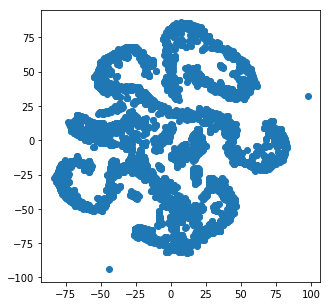

Figure 3: the 2D projection of the 81-dimensional feature space we created by extracting features from the time series. The separation of the objects in the t-distribution based stocastic neighbourhood embedding (t-SNE) is promising: t-SNE is an embedding (a transformation to a different coordinate space) which is designed to preserve Eucledianpairwise distances existing in the higher dimensional parameter space. How many clusters can you see in this embedding?A note: since the t_SNE produces a projection of the feature space on an ideal set of coordinates, this is the only cxase in which you are allowed not to label your axes!


In [49]:
X_embedded = TSNE(n_components=2, random_state=345).fit_transform(X)
X_embedded.shape
pl.figure(figsize=(5,5))
pl.scatter(X_embedded[:,0], X_embedded[:,1])
pl.show()
print("Figure 3: the 2D projection of the 81-dimensional feature space we created by extracting features from the time series. " + 
      "The separation of the objects in the t-distribution based stocastic neighbourhood embedding (t-SNE) is promising: " + 
      "t-SNE is an embedding (a transformation to a different coordinate space) which is designed to preserve Eucledian" + 
      "pairwise distances existing in the higher dimensional parameter space. " + 
      "How many clusters can you see in this embedding?" + 
      "A note: since the t_SNE produces a projection of the feature space on an ideal set of coordinates, " + 
      "this is the only cxase in which you are allowed not to label your axes!")

We have to assure that the clusters map to the target variable tho. So I will redo the plot colorcoded by target variable

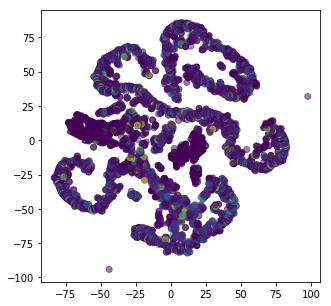

In [57]:
norm_obj= Normalize(vmin=y.min(), vmax=y.max())
len([c for c in pl.cm.RdBu_r(norm_obj(y.values))]), X_embedded.shape
pl.figure(figsize=(5,5))
pl.scatter(X_embedded[:,0], X_embedded[:,1],  
           color=[c for c in pl.cm.viridis(norm_obj(y.values))], alpha=0.5);

Figure 4: the purity of the sample is not good in the t-SNE projection against the target variable.

Does this map better on other features in the metadata?

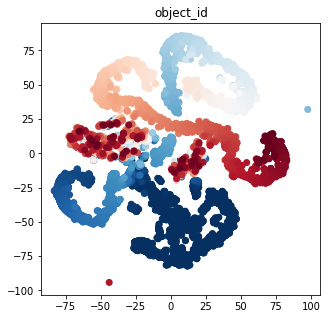

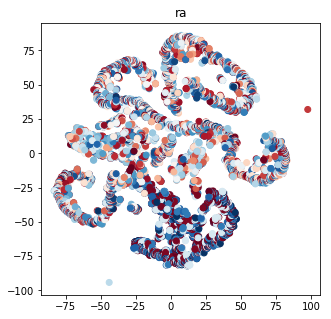

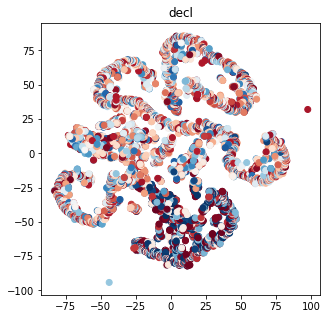

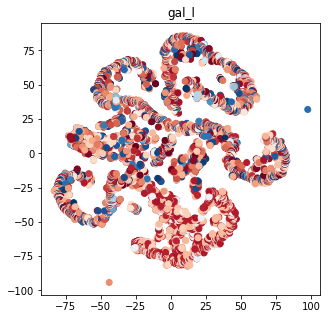

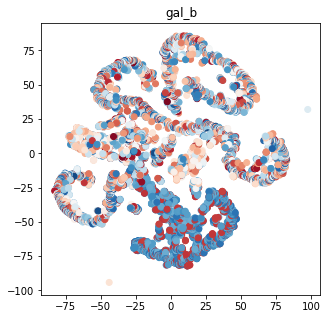

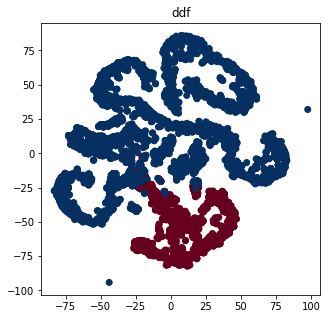

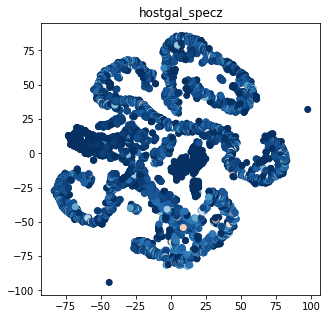

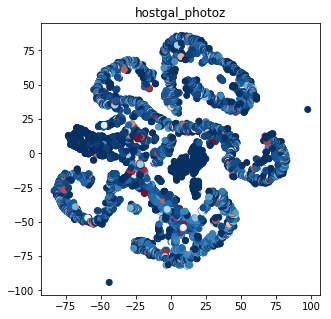

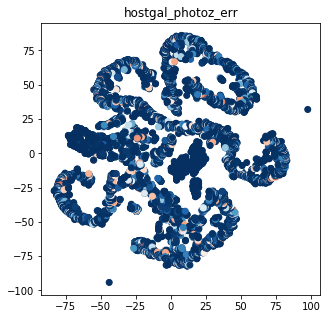

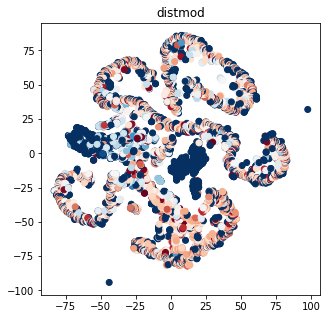

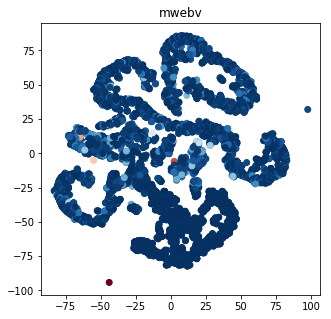

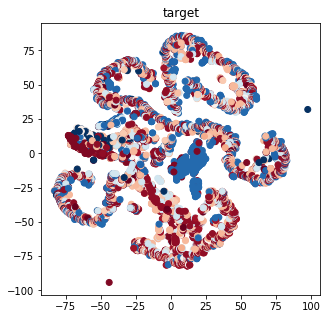

In [51]:
for col in metadata.columns:
    v = metadata[col].astype(float)
    plt.figure(figsize=(5,5))
    plt.title(col)
    plt.scatter(X_embedded[:,0], X_embedded[:,1],  color=[plt.cm.RdBu_r(Normalize(vmin=v.min(), vmax=v.max())(c))
                                                         for c in v])

    plt.show()

**Figure 5.** It shows a 2D t-SNE projection of all feature space.